
# Random Forest on foam table (with heights/volumes, lamella excluded)
Inputs: surfactant wt%, time (and temperature if present).
Outputs: bubble metrics, radii, heights/volumes, half-life. Saves to `foam_rfr.pkl`.


In [2]:
from pathlib import Path

# Use the merged table that includes Al2O3 nanoparticle wt.%
CSV_PATH = Path('foam_training_table_with_nano.csv')
if not CSV_PATH.exists():
    raise FileNotFoundError(f"Missing table: {CSV_PATH}")
MODEL_PATH = Path('foam_rfr.pkl')
print('Using data:', CSV_PATH.resolve())

Using data: C:\Users\aisci\OneDrive\Desktop\Foam bubble data\AisciaMicroscopeHackathon\DTMicroscope\notebooks\foam\foam_training_table_with_nano.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load data
df = pd.read_csv(CSV_PATH)

# Inputs: time, surfactant wt% columns, nanoparticle wt%
required_inputs = [
    'time_s',
    'surfactant_coco_b_wt_pct',
    'surfactant_coco_betain_wt_pct',
    'surfactant_capryl_glucoside_wt_pct',
    'surfactant_coco_glucoside_wt_pct',
    'nanoparticle_al2o3_wt_pct',
]
optional_inputs = ['temperature_c']

available_inputs = [c for c in required_inputs if c in df.columns]
missing_required = [c for c in required_inputs if c not in df.columns]
if missing_required:
    raise ValueError(f"Missing required input columns: {missing_required}")
for opt in optional_inputs:
    if opt in df.columns:
        available_inputs.append(opt)

# Outputs: bubble metrics + lamella + half-life (no height/volume fields here)
target_cols = [
    'BC [mm??]', 'M?B?A? [?m?]', 'SD M?B?A? [?m?]', 'Ravg [?m]', 'Rrms [?m]', 'R21 [?m]', 'R32 [?m]',
    'metric_v', 'metric_w',
    'lamella_thickness_mm', 'half_life_s',
]
missing_targets = [c for c in target_cols if c not in df.columns]
if missing_targets:
    raise ValueError(f"Missing target columns: {missing_targets}")

# Drop utility columns not used for training
for util in ['dataset_name', 'frame_index']:
    if util in df.columns:
        df = df.drop(columns=util)

X = df[available_inputs].copy()
y = df[target_cols].copy()

# Median-fill any numeric gaps
X = X.fillna(X.median(numeric_only=True))
y = y.fillna(y.median(numeric_only=True))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.19, random_state=42, shuffle=True
)

# Model config
model = RandomForestRegressor(
    n_estimators=280,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train, y_train)

# Evaluate
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
train_r2 = r2_score(y_train, train_pred, multioutput='uniform_average')
test_r2 = r2_score(y_test, test_pred, multioutput='uniform_average')

print(f"Inputs used: {available_inputs}")
print(f"Train RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")

# Save
joblib.dump({'model': model, 'input_cols': available_inputs, 'target_cols': target_cols}, MODEL_PATH)
print('Saved model to', MODEL_PATH.resolve())

Inputs used: ['time_s', 'surfactant_coco_b_wt_pct', 'surfactant_coco_betain_wt_pct', 'surfactant_capryl_glucoside_wt_pct', 'surfactant_coco_glucoside_wt_pct', 'nanoparticle_al2o3_wt_pct']
Train RMSE: 57840.8280, R2: 0.8684
Test  RMSE: 68592.7718, R2: 0.7722
Saved model to C:\Users\aisci\OneDrive\Desktop\Foam bubble data\AisciaMicroscopeHackathon\DTMicroscope\notebooks\foam\foam_rfr.pkl


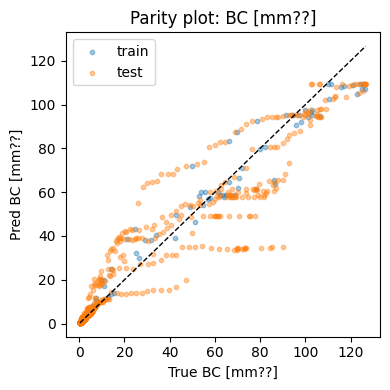

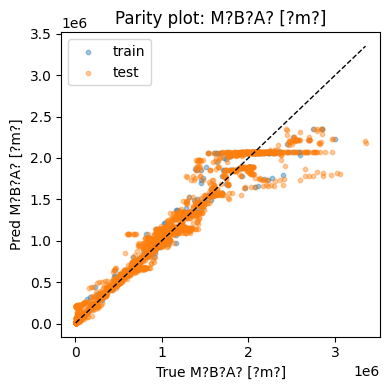

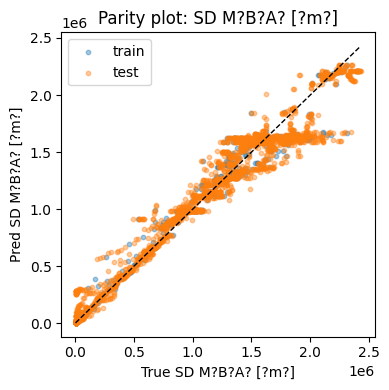

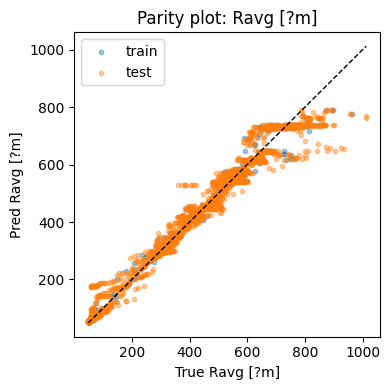

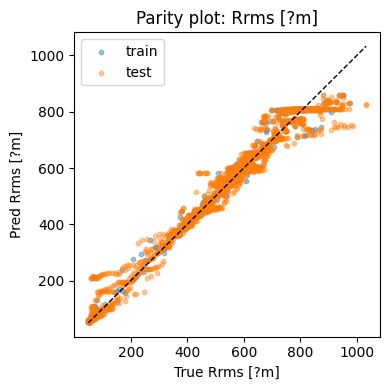

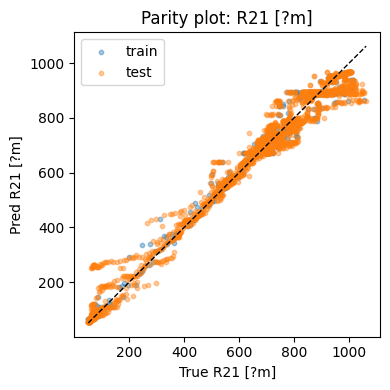

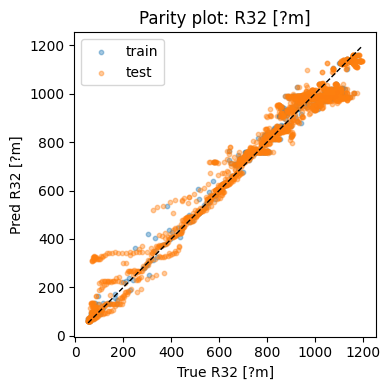

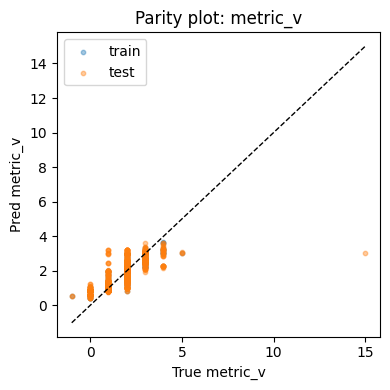

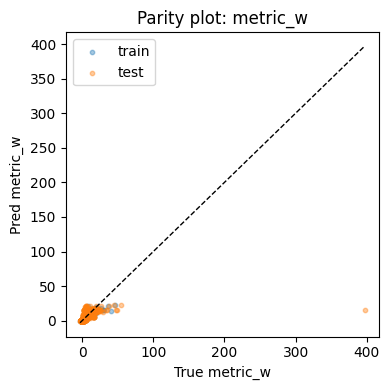

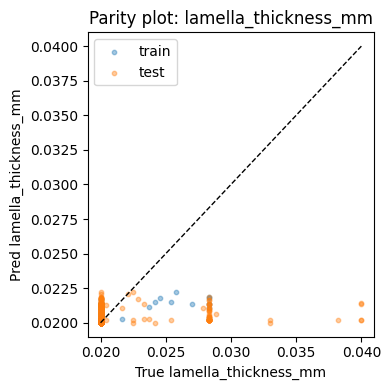

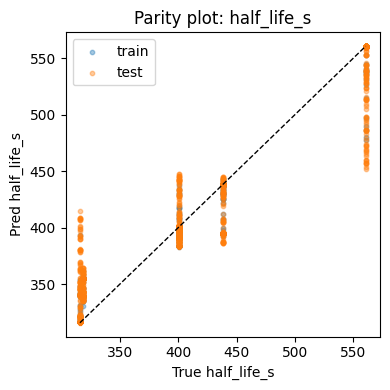

In [4]:

# Parity plots for train and test sets
import matplotlib.pyplot as plt
import pandas as pd

# Build DataFrames for convenience
train_df = pd.DataFrame(train_pred, columns=target_cols)
train_true = y_train.reset_index(drop=True)
test_df = pd.DataFrame(test_pred, columns=target_cols)
test_true = y_test.reset_index(drop=True)

for col in target_cols:
    plt.figure(figsize=(4,4))
    plt.scatter(train_true[col], train_df[col], alpha=0.4, label='train', s=10)
    plt.scatter(test_true[col], test_df[col], alpha=0.4, label='test', s=10)
    lims = [min(train_true[col].min(), test_true[col].min(), train_df[col].min(), test_df[col].min()),
            max(train_true[col].max(), test_true[col].max(), train_df[col].max(), test_df[col].max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel(f'True {col}')
    plt.ylabel(f'Pred {col}')
    plt.title(f'Parity plot: {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()


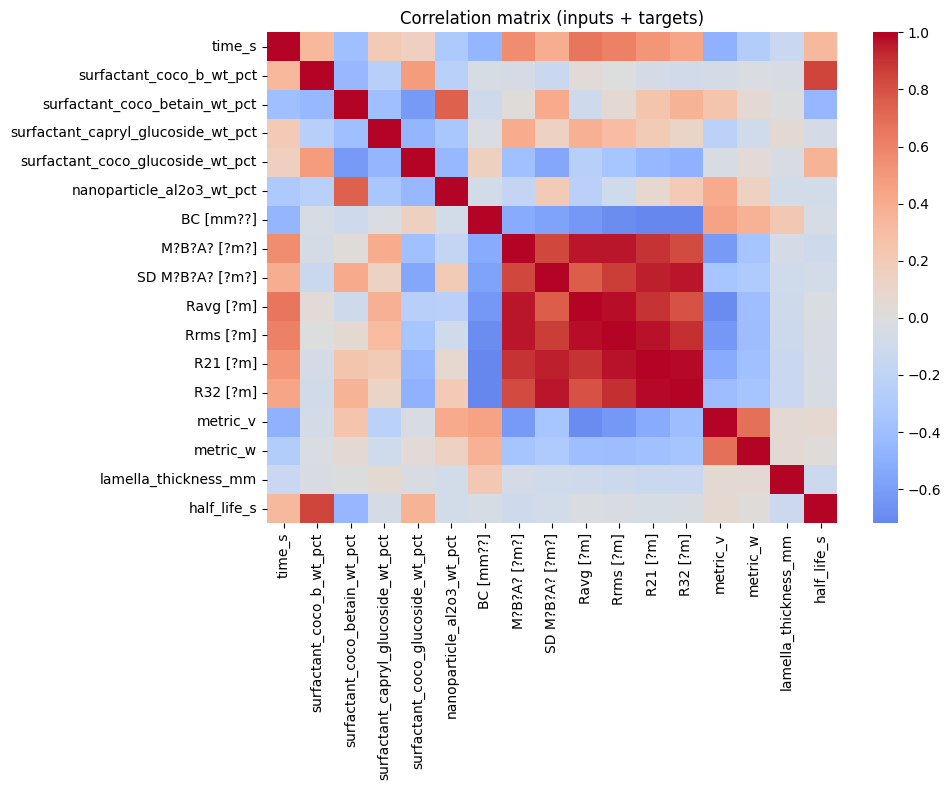

In [6]:

# Correlation matrix of inputs and targets
import matplotlib.pyplot as plt
import seaborn as sns

corr_cols = available_inputs + target_cols
corr_df = df[corr_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_df, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation matrix (inputs + targets)')
plt.tight_layout()
plt.show()


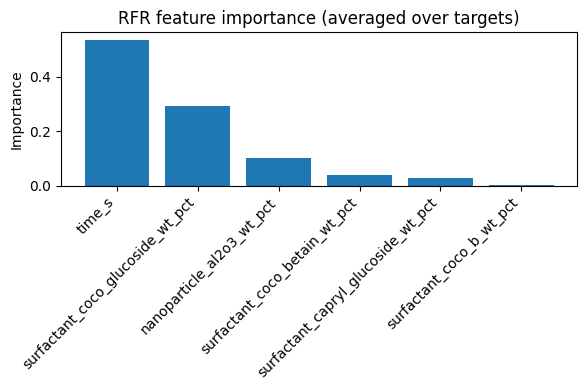

In [7]:

# Feature importance (mean over targets) from the multi-output RFR
import matplotlib.pyplot as plt
import numpy as np

# model.feature_importances_ is averaged over targets in multi-output RF
importances = model.feature_importances_
idx = np.argsort(importances)[::-1]
plt.figure(figsize=(6,4))
plt.bar([available_inputs[i] for i in idx], importances[idx])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance')
plt.title('RFR feature importance (averaged over targets)')
plt.tight_layout()
plt.show()


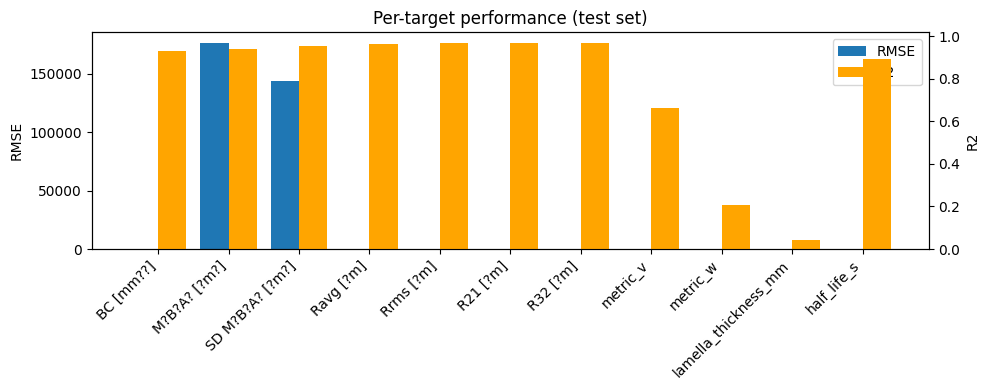

In [8]:

# Per-target performance bars (RMSE and R2)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

rmse_list = []
r2_list = []
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(y_test[col], test_pred[:, target_cols.index(col)]))
    r2 = r2_score(y_test[col], test_pred[:, target_cols.index(col)])
    rmse_list.append(rmse)
    r2_list.append(r2)

x = np.arange(len(target_cols))
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.bar(x - 0.2, rmse_list, width=0.4, label='RMSE')
ax1.set_ylabel('RMSE')
ax2 = ax1.twinx()
ax2.bar(x + 0.2, r2_list, width=0.4, color='orange', label='R2')
ax2.set_ylabel('R2')
ax1.set_xticks(x)
ax1.set_xticklabels(target_cols, rotation=45, ha='right')
plt.title('Per-target performance (test set)')
# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1+handles2, labels1+labels2, loc='upper right')
plt.tight_layout()
plt.show()


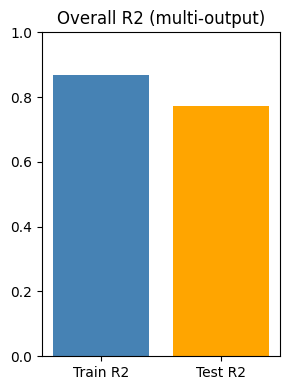

In [9]:

# Overall R2 bars for train vs test
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

train_r2_overall = r2_score(y_train, train_pred, multioutput='uniform_average')
test_r2_overall = r2_score(y_test, test_pred, multioutput='uniform_average')

plt.figure(figsize=(3,4))
plt.bar(['Train R2','Test R2'], [train_r2_overall, test_r2_overall], color=['steelblue','orange'])
plt.ylim(0,1)
plt.title('Overall R2 (multi-output)')
plt.tight_layout()
plt.show()
